### camera shake detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os

from scipy.spatial.distance import cosine
import cv2

In [73]:

def video2frames(video):
    capture_obj = cv2.VideoCapture(video)
        
    frameNr = 0
    frames = []
    while (True):
        success, frame = capture_obj.read()
        if success:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, (256, 256))
            frames.append(frame)
        else:
            # print("ERR: Cann't find the file")
            break
    capture_obj.release()
    
    
    return frames
    

In [3]:
def get_corner_blocks(matrix):
    """
    This function takes a square matrix and returns a list of smaller square matrices
    representing its corner blocks.
    """
    size = len(matrix)
    block_size = size // 2
    blocks = []
    
    # Upper left block
    blocks.append(matrix[:block_size, :block_size])
    
    # Upper right block
    blocks.append(matrix[:block_size, block_size:])
    
    # Lower left block
    blocks.append(matrix[block_size:, :block_size])
    
    # Lower right block
    blocks.append(matrix[block_size:, block_size:])
    
    return blocks


In [192]:
# def shakeornot(frames):
    
# #     for i in range(0, len(frames)-1):
#     keypoints_1 = None
#     keypoints_2 = None
#     descriptors_1 = None
#     descriptors_2 = None
#     pts1 = []
#     pts2 = []
    
#     img1 = frames[0]
#     img2 = frames[1]

#     #sift
#     sift = cv2.xfeatures2d.SIFT_create()

#     keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
#     keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#     #(x,y) coordinates
    
# #     print(keypoints_1[0].pt)
    
#     pts1 = [kp1.pt for kp1 in keypoints_1]
#     pts2 = [kp2.pt for kp2 in keypoints_2]
    
# #     print(len(pts1))
# #     print()
# #     print(len(pts2))

#     #feature matching
#     bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

#     matches = bf.match(descriptors_2, descriptors_1)
#     print(len(matches))
#     matches = sorted(matches, key = lambda x:x.distance)

#     img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, bmatches[:50], img2, flags=2)
#     plt.imshow(img3),plt.show()

#     return matches
   

In [64]:
shake_folder = r"D:\data\final_data\shake"

bfiles = os.listdir(shake_folder)

print(bfiles)

bframes = video2frames(os.path.join(shake_folder, bfiles[3]))

print(bframes[0].shape)

# bfilename = "surveillance_shake (4).mp4"

['surveillance_shake (1).mp4', 'surveillance_shake (2).mp4', 'surveillance_shake (3).mp4', 'surveillance_shake (4).mp4']
(512, 512)


In [28]:
# # print(os.path.join(shake_folder, bfilename))

# for bfilename in bfiles:
#     bframes = video2frames(os.path.join(shake_folder, bfilename))
#     bmatches = shakeornot(bframes)
#     # print

#     d = [e.distance for e in bmatches]
#     print(d)
#     print(len(d))
#     print()

# # print(frames)

In [12]:
# bmatches = shakeornot(bframes)
# # print

# d = [e.distance for e in bmatches]
# print(d)
# print(len(d))

In [124]:
good_folder = r"D:\data\final_data\good"
gfiles = os.listdir(good_folder)

print(gfiles)

gframes = video2frames(os.path.join(good_folder, gfiles[1]))

print(gframes[0].shape)

['fuq6.mp4', 'good1.mp4', 'good3.mp4', 'Highway1.mp4', 'yqmu.mp4', 'Bus_Stop.mp4']
(512, 512)


In [84]:
# print(os.path.join(good_folder, gfilename))
# gframes = video2frames(os.path.join(good_folder, gfilename))

# print(frames)

D:\data\final_data\good\Bus_Stop.mp4


In [13]:
# # print(os.path.join(shake_folder, bfilename))

# for gfilename in gfiles:
#     gframes = video2frames(os.path.join(good_folder, gfilename))
    
#     print(os.path.join(good_folder, gfilename))
#     gmatches = shakeornot(gframes)
#     # print

#     d = [e.distance for e in gmatches]
#     print(d)
#     print(len(d))
#     print()

# # print(frames)

In [4]:
def get_keypoints_and_descriptors(img):
    
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img,None)
    
    return (keypoints, descriptors)

In [5]:
def get_matches(descriptors_1, descriptors_2):
#     # BFMatcher with default params
#     bf = cv.BFMatcher()
#     matches = bf.knnMatch(des1,des2,k=2)
    
    matches = None
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)
#     print(len(matches))
    # Apply ratio test
    good = None
    if matches is not None and len(matches[0]) > 1:
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append(m)
        gmatches = sorted(good, key = lambda x:x.distance)
#     print('------',good[0].distance)
    
    return good

In [6]:
from statistics import mean
import random 

def get_reference_point(curr_frame, next_frame):
    
    curr_frame_blocks = get_corner_blocks(curr_frame)
    next_frame_blocks = get_corner_blocks(next_frame)

    cfd = []
    reference_points = []
    for corner1, corner2 in zip(curr_frame_blocks, next_frame_blocks):
        matches = None
        curr_keypoints = None
        next_keypoints = None
        curr_descriptors = None
        next_descriptors = None
        curr_keypoints, curr_descriptors = get_keypoints_and_descriptors(corner1)
        next_keypoints, next_descriptors = get_keypoints_and_descriptors(corner2)
#         print(curr_keypoints, next_descriptors)
#         print('-----------------')
#         if curr_keypoints is not None and next_keypoints is not None:
        if curr_descriptors is not None and next_descriptors is not None:
            if curr_keypoints is not None and next_keypoints is not None:
#                 print('kp and desc are there in corner')
                matches = get_matches(curr_descriptors, next_descriptors)
#         print('kp not there.')
                if matches is not None and len(matches) >= 1:
                    if len(matches) == 1:
#                         print('single match')
                        match = matches[0]
                    if len(matches) > 1:
#                         print('multiple matches')
                        seed_constant = 27
                        random.seed(seed_constant)
                        match = random.choice(matches)
                    p1 = curr_keypoints[match.queryIdx].pt
                    p2 = next_keypoints[match.trainIdx].pt
                    p1 = (round(p1[0]), round(p1[1]))
                    p2 = (round(p2[0]), round(p2[1]))
                    reference_points.append((p1, p2))
                else:
                    p1 = (-1, -1)
                    p2 = (-1, -1)
                    reference_points.append((p1, p2))
#                     print('no matches')
                    pass
            else:
#                 print('no kps')
                pass
        else:
#             print('no desc')
            pass
    return reference_points


In [96]:
def get_direction(points_list):
    if len(points_list) == 4:
        first_corner = points_list[0]
        sec_corner = points_list[1]
        third_corner = points_list[2]
        fourth_corner = points_list[3]
        
        if first_corner[0][0] == first_corner[1][0] and sec_corner[0][0] == sec_corner[1][0] and third_corner[0][0] == third_corner[1][0] and fourth_corner[0][0] == fourth_corner[1][0]:
            return 'no_shake'
        elif first_corner[0][1] < first_corner[1][1] and sec_corner[0][1] == sec_corner[1][1] and third_corner[0][1] == third_corner[1][1] and fourth_corner[0][1] == fourth_corner[1][1]:
            return 'no_shake'      
        elif first_corner[0][0] < first_corner[1][0] and sec_corner[0][0] < sec_corner[1][0] and third_corner[0][0] < third_corner[1][0] and fourth_corner[0][0] < fourth_corner[1][0]:
            return 'left'
        elif first_corner[0][0] > first_corner[1][0] and sec_corner[0][0] > sec_corner[1][0] and third_corner[0][0] > third_corner[1][0] and fourth_corner[0][0] > fourth_corner[1][0]:
            return 'right'
        elif first_corner[0][1] < first_corner[1][1] and sec_corner[0][1] < sec_corner[1][1] and third_corner[0][1] < third_corner[1][1] and fourth_corner[0][1] < fourth_corner[1][1]:
            return 'up'
        elif first_corner[0][1] > first_corner[1][1] and sec_corner[0][1] > sec_corner[1][1] and third_corner[0][1] > third_corner[1][1] and fourth_corner[0][1] > fourth_corner[1][1]:
            return 'down'
        else:
            return 'shake'
    else:
#         print('no enough pts.')
        return 'shake'
    

In [120]:
camera_shake(bframes)

1 th frame is shaky.
2 th frame is shaky.
3 th frame is shaky.
4 th frame is shaky.
5 th frame is shaky.
6 th frame is shaky.
7 th frame is shaky.
8 th frame is shaky.
9 th frame is shaky.
10 th frame is shaky.
11 th frame is shaky.
12 th frame is shaky.
13 th frame is shaky.
14 th frame is shaky.
15 th frame is shaky.
16 th frame is shaky.
17 th frame is shaky.
18 th frame is shaky.
19 th frame is shaky.
20 th frame is shaky.
21 th frame is shaky.
22 th frame is shaky.
23 th frame is shaky.
24 th frame is shaky.
25 th frame is shaky.
26 th frame is shaky.
27 th frame is shaky.
28 th frame is shaky.
29 th frame is shaky.
30 th frame is shaky.
31 th frame is shaky.
32 th frame is shaky.
33 th frame is shaky.
34 th frame is shaky.
35 th frame is shaky.
36 th frame is shaky.
37 th frame is shaky.
38 th frame is shaky.
39 th frame is shaky.
40 th frame is shaky.
41 th frame is shaky.
42 th frame is shaky.
43 th frame is shaky.
44 th frame is shaky.
45 th frame is shaky.
46 th frame is shak

In [125]:
camera_shake(gframes)

107 th frame is shaky.
172 th frame is shaky.


In [101]:
vid_path = r"D:\data\final_data\shake\shaky3.mp4"
# vid_path = r"D:\data\final_data\shake\surveillance_shake (3).mp4"
tframes = video2frames(vid_path)

print(len(tframes))
# ps = get_reference_point(tframes[10], tframes[11])
# print(ps)
# print(get_direction(ps))
# print()
# ps1 = get_reference_point(tframes[8], tframes[9])
# print(ps1)
# print(get_direction(ps1))


301


In [102]:
ps = None
ps1 = None
r1 = None
r2 = None

freq = {'shake': 4, 'no_shake': 0}
directions = []
for i in range(0, len(tframes)-4):
#     print(i)
    ps = get_reference_point(tframes[i], tframes[i+1])
    ps1 = get_reference_point(tframes[i+2], tframes[i+3])
#     print(ps, ps1)
#     print('-----------------------')
    r1 = get_direction(ps)
    r2 = get_direction(ps1)
    if (r1 == r2) and (r1 != 'shake' or r2 != 'shake'):
        freq['no_shake'] += 1
    elif r1 == 'no_shake' or r2 == 'no_shake':
        freq['no_shake'] += 1
    else:
        freq['shake'] += 1
        

print(freq)

{'shake': 267, 'no_shake': 34}


"D:\data\final_data\shake\shaky1.mp4" - {'shake': 150, 'no_shake': 150} - 300 frames - video 8 - 1920x1080 - 10sec

"D:\data\final_data\shake\shaky2.mp4" - {'shake': 211, 'no_shake': 90} - 301 - video 4 - 1920x1080 - 10sec

"D:\data\final_data\shake\shaky3.mp4" - {'shake': 288, 'no_shake': 13} - 301 - video 5 - 1920x1080 - 10sec

"D:\data\final_data\shake\shaky4.mp4" - {'shake': 278, 'no_shake': 22} - 300 - video 6 - 1920x1080 - 10sec

"D:\data\final_data\shake\skulls-on-fence.mp4" - {'shake': 178, 'no_shake': 32} - 210 - video 1 - 1920x1080 - 7sec

"D:\data\final_data\shake\surveillance_shake (2).mp4" - {'shake': 275, 'no_shake': 25} - 300 - video 2 - 1920x1080 - 10sec

"D:\data\final_data\shake\surveillance_shake (3).mp4" - {'shake': 184, 'no_shake': 111} - 295 - video 7 - 1280x720 - 10sec

"D:\data\final_data\shake\surveillance_shake (4).mp4" - {'shake': 198, 'no_shake': 103} - 301 - video 3 - 1280x720 - 10sec

                      videos  accuracy
0                 video1       0.84700
1                 video2       0.91600
2                 video3       0.65700
3                 video4       0.70000
4                 video5       0.95600
5                 video6       0.92600
6                 video7       0.62300
7                 video8       0.50000
8      average\naccuracy       0.79826


[Text(0.5, 0, '')]

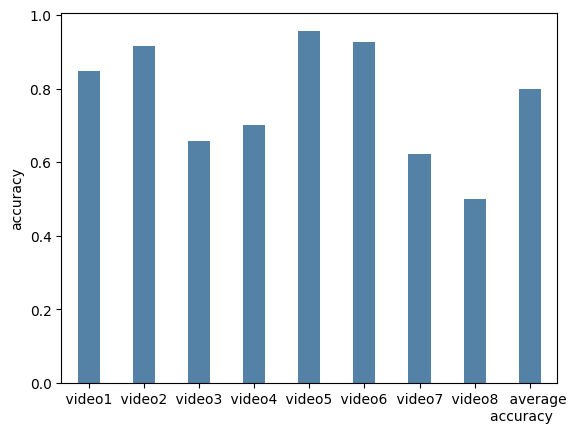

In [186]:
import seaborn as sns
import pandas as pd

# 1, 3, 4, 6, 8

videos = [1,2,3,4,5,6,7,8]
accuracy = [0.847, 0.916, 0.657, 0.700, 0.956, 0.926, 0.623, 0.5]

data = [['    video1    ', 0.847], ['    video2    ', 0.916], ['    video3    ', 0.657], ['    video4    ', 0.700], 
        ['    video5    ', 0.956], ['    video6    ', 0.926], ['    video7    ', 0.623], ['    video8    ', 0.500], ['    average\naccuracy    ', 0.79826]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['videos', 'accuracy'])

print(df)

ax = sns.barplot(data = df, x = 'videos', y = 'accuracy', width = 0.4, color='steelblue')
ax.set(xlabel=None)

    videos  accuracy                          methods
0   video1     0.847            corners SIFT matching
1   video2     0.916            corners SIFT matching
2   video3     0.657            corners SIFT matching
3   video4     0.700            corners SIFT matching
4   video5     0.956            corners SIFT matching
5   video6     0.926            corners SIFT matching
6   video7     0.623            corners SIFT matching
7   video8     0.500            corners SIFT matching
8   video1     0.642  classification-based homography
9   video2     0.497  classification-based homography
10  video3     0.432  classification-based homography
11  video4     0.586  classification-based homography
12  video5     0.319  classification-based homography
13  video6     0.618  classification-based homography
14  video7     0.297  classification-based homography
15  video8     0.526  classification-based homography
16  video1     0.768                    write-a-video
17  video2     0.535        

[Text(0.5, 0, '')]

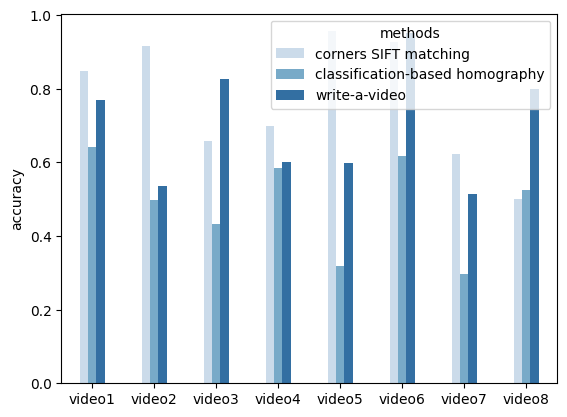

In [164]:
# 1, 3, 4, 6, 8

data = [['video1', 0.847, 'corners SIFT matching'], ['video2', 0.916, 'corners SIFT matching'], ['video3', 0.657, 'corners SIFT matching'], ['video4', 0.700, 'corners SIFT matching'], 
        ['video5', 0.956, 'corners SIFT matching'], ['video6', 0.926, 'corners SIFT matching'], ['video7', 0.623, 'corners SIFT matching'], ['video8', 0.500, 'corners SIFT matching'],
       ['video1', 0.642, 'classification-based homography'], ['video2', 0.497, 'classification-based homography'], ['video3', 0.432, 'classification-based homography'], ['video4', 0.586, 'classification-based homography'], 
        ['video5', 0.319, 'classification-based homography'], ['video6', 0.618, 'classification-based homography'], ['video7', 0.297, 'classification-based homography'], ['video8', 0.526, 'classification-based homography'],
       ['video1', 0.768, 'write-a-video'], ['video2', 0.535, 'write-a-video'], ['video3', 0.826, 'write-a-video'], ['video4', 0.602, 'write-a-video'], 
        ['video5', 0.597, 'write-a-video'], ['video6', 0.952, 'write-a-video'], ['video7', 0.514, 'write-a-video'], ['video8', 0.799, 'write-a-video']]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['videos', 'accuracy', 'methods'])

print(df)


ax = sns.barplot(data = df, x = 'videos', y = 'accuracy', hue = 'methods', width = 0.4, palette = 'Blues')
ax.set(xlabel=None)
# plt.legend(loc='upper right')

In [152]:
from sklearn import preprocessing

fprs = [np.array([32, 25, 103, 90, 13, 22, 11, 150])]
n_fprs = preprocessing.normalize(fprs)

# less = min(fprs)
# more = max(fprs)

# for i in fprs:
#     t = round(((abs(i - less)) / (more - less)) * 100)
#     n_fprs.append(t)

print(n_fprs)

[[0.153196   0.11968437 0.49309962 0.43086374 0.06223587 0.10532225
  0.05266112 0.71810624]]


    videos  false_positive_rate                          methods
0   video1             0.153196            corners SIFT matching
1   video2             0.119684            corners SIFT matching
2   video3             0.493100            corners SIFT matching
3   video4             0.430864            corners SIFT matching
4   video5             0.062236            corners SIFT matching
5   video6             0.105322            corners SIFT matching
6   video7             0.052661            corners SIFT matching
7   video8             0.618106            corners SIFT matching
8   video1             0.412079  classification-based homography
9   video2             0.736172  classification-based homography
10  video3             0.801126  classification-based homography
11  video4             0.678207  classification-based homography
12  video5             0.898363  classification-based homography
13  video6             0.413291  classification-based homography
14  video7             0.

[Text(0.5, 0, '')]

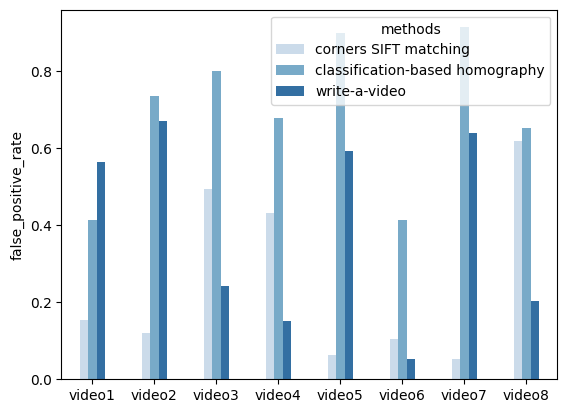

In [163]:
# data = [['video1', 0.153196], ['video2', 0.11968437], ['video3', 0.49309962], ['video4', 0.43086374], 
#         ['video5', 0.06223587], ['video6', 0.10532225], ['video7', 0.05266112], ['video8', 0.61810624]]

# data = [['video1', 0.847], ['video2', 0.916], ['video3', 0.657], ['video4', 0.700], 
#         ['video5', 0.956], ['video6', 0.926], ['video7', 0.623], ['video8', 0.500]]

data = [['video1', 0.153196, 'corners SIFT matching'], ['video2', 0.11968437, 'corners SIFT matching'], ['video3', 0.49309962, 'corners SIFT matching'], ['video4', 0.43086374, 'corners SIFT matching'], 
        ['video5', 0.06223587, 'corners SIFT matching'], ['video6', 0.10532225, 'corners SIFT matching'], ['video7', 0.05266112, 'corners SIFT matching'], ['video8', 0.61810624, 'corners SIFT matching'],
       ['video1', 0.41207863, 'classification-based homography'], ['video2', 0.7361723, 'classification-based homography'], ['video3', 0.80112644, 'classification-based homography'], ['video4', 0.67820694, 'classification-based homography'], 
        ['video5', 0.8983629, 'classification-based homography'], ['video6', 0.41329069, 'classification-based homography'], ['video7', 0.9134087, 'classification-based homography'], ['video8', 0.65113681, 'classification-based homography'],
       ['video1', 0.56319360, 'write-a-video'], ['video2', 0.671105931, 'write-a-video'], ['video3', 0.2410496, 'write-a-video'], ['video4', 0.15248922, 'write-a-video'], 
        ['video5', 0.59183723, 'write-a-video'], ['video6', 0.05232897, 'write-a-video'], ['video7', 0.6381067118, 'write-a-video'], ['video8', 0.2034672, 'write-a-video']]
  
  
# Create the pandas DataFrame
df_fp = pd.DataFrame(data, columns=['videos', 'false_positive_rate', 'methods'])

print(df_fp)

ax = sns.barplot(data = df_fp, x = 'videos', y = 'false_positive_rate', hue = 'methods', width = 0.4, palette = 'Blues')
ax.set(xlabel=None)